# GCC Prediction Model (PEG_FUSION_0)

#### This script is intented to develop some approach using mahine learning models to predict future greenness of plants.
#### Input Features: 
##### 1. gcc_90 value of 20 days from last year : (t-10)th to (t+9)th day                          
##### 2. Weather variables ('radiation', 'max_temp', 'min_temp', 'precipitation’)
#### Target Variable: gcc_90
###### Current weather data extracted from Daymet.

#### Approach: Fuse multiple machine learning models to predict the value and standard deviation of the target variable. ML models used: Random Forest Regressor, ElasticNet and Extreme Gradient Boosting. 

In [1]:
# Importing all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
import pickle

In [2]:
# Importing the phenology-targets dataset from ecological forecasting website 
url = "https://data.ecoforecast.org/targets/phenology/phenology-targets.csv.gz"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)
dataset

Shape of imported dataset:(39978, 6)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'rcc_90', 'gcc_sd', 'rcc_sd'], dtype='object')


time siteID   gcc_90   rcc_90    gcc_sd    rcc_sd
0      2016-01-29   BART      NaN      NaN       NaN       NaN
1      2016-01-30   BART      NaN      NaN       NaN       NaN
2      2016-01-31   BART      NaN      NaN       NaN       NaN
3      2016-02-01   BART      NaN      NaN       NaN       NaN
4      2016-02-02   BART      NaN      NaN       NaN       NaN
...           ...    ...      ...      ...       ...       ...
39973  2022-02-22   WOOD  0.33425  0.32315  0.000387  0.013861
39974  2022-02-23   WOOD  0.33537  0.33095  0.000387  0.013861
39975  2022-02-24   WOOD  0.33685  0.33339  0.000387  0.013861
39976  2022-02-25   WOOD  0.33656  0.33462  0.000387  0.013861
39977  2022-02-26   WOOD  0.33778  0.33765  0.000387  0.013861

[39978 rows x 6 columns]

In [3]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
#dataset = dataset.set_index("time")

site_list = dataset["siteID"].unique()
print("Sites:")
print(site_list)

Sites:
['BART' 'CLBJ' 'CPER' 'DELA' 'DSNY' 'GRSM' 'HARV' 'JORN' 'KONZ' 'MLBS'
 'OAES' 'ONAQ' 'SCBI' 'SERC' 'SRER' 'STEI' 'UKFS' 'WOOD']


In [4]:
num_sites = len(site_list)
num_sites

18

In [5]:
url = "gcc_weather.csv"
weather_data = pd.read_csv(url)
print("Shape of imported dataset:" + str(weather_data.shape))
print("\nColumns of imported dataset:")
print(weather_data.columns)
weather_data.rename(columns = {'date':'time'}, inplace = True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

Shape of imported dataset:(39852, 6)

Columns of imported dataset:
Index(['date', 'siteID', 'radiation', 'max_temp', 'min_temp', 'precip'], dtype='object')


In [48]:
# Merging weather data and phenology data
dataset = pd.merge(left = dataset, right = weather_data, how='outer', left_on=['time','siteID'], right_on=['time','siteID'])
dataset

time siteID   gcc_90   rcc_90    gcc_sd    rcc_sd  year  month  \
0     2016-01-29   BART      NaN      NaN       NaN       NaN  2016      1   
1     2016-01-30   BART      NaN      NaN       NaN       NaN  2016      1   
2     2016-01-31   BART      NaN      NaN       NaN       NaN  2016      1   
3     2016-02-01   BART      NaN      NaN       NaN       NaN  2016      2   
4     2016-02-02   BART      NaN      NaN       NaN       NaN  2016      2   
...          ...    ...      ...      ...       ...       ...   ...    ...   
39973 2022-02-22   WOOD  0.33425  0.32315  0.000387  0.013861  2022      2   
39974 2022-02-23   WOOD  0.33537  0.33095  0.000387  0.013861  2022      2   
39975 2022-02-24   WOOD  0.33685  0.33339  0.000387  0.013861  2022      2   
39976 2022-02-25   WOOD  0.33656  0.33462  0.000387  0.013861  2022      2   
39977 2022-02-26   WOOD  0.33778  0.33765  0.000387  0.013861  2022      2   

       day year_month  radiation_x  max_temp_x  min_temp_x  precip_x  \
0       29     2016-1     8.591550        1.71      -10.12       0.0   
1       30     2016-1     6.506730        2.39       -5.04       0.0   
2       31     2016-1     8.554779        7.29       -4.20       0.0   
3        1     2016-2     9.190341       10.82       -2.76       0.0   
4        2     2016-2     7.378106        5.26       -3.59       0.0   
...    ...        ...          ...         ...         ...       ...   
39973   22     2022-2          NaN         NaN         NaN       NaN   
39974   23     2022-2          NaN         NaN         NaN       NaN   
39975   24     2022-2          NaN         NaN         NaN       NaN   
39976   25     2022-2          NaN         NaN         NaN       NaN   
39977   26     2022-2          NaN         NaN         NaN       NaN   

       radiation_y  max_temp_y  min_temp_y  precip_y  
0         8.591550        1.71      -10.12       0.0  
1         6.506730        2.39       -5.04       0.0  
2         8.554779        7.29       -4.20       0.0  
3         9.190341       10.82       -2.76       0.0  
4         7.378106        5.26       -3.59       0.0  
...            ...         ...         ...       ...  
39973          NaN         NaN         NaN       NaN  
39974          NaN         NaN         NaN       NaN  
39975          NaN         NaN         NaN       NaN  
39976          NaN         NaN         NaN       NaN  
39977          NaN         NaN         NaN       NaN  

[39978 rows x 18 columns]

In [49]:
# Selecting the required columns for the training
gcc_data = dataset[["time", "year", "month", "day", "year_month", "siteID", "gcc_90", 
                    "radiation", "max_temp", "min_temp", "precip"]]
print("Shape of gcc_data:" + str(gcc_data.shape))

rcc_data = dataset[["time", "year", "month", "day", "year_month", "siteID", "rcc_90", 
                    "radiation", "max_temp", "min_temp", "precip"]]
print("Shape of rcc_data:" + str(rcc_data.shape))

#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
gcc_site_data = []
for i in range(0,num_sites):
    gcc_site_data.append(gcc_data_by_site.get_group(site_list[i]))
    
# Selecting the required columns: siteID and rcc_90 and date related columns    
rcc_data_by_site = rcc_data.groupby("siteID")
rcc_site_data = []
for i in range(0,num_sites):
    rcc_site_data.append(rcc_data_by_site.get_group(site_list[i]))

for i in range(0,num_sites):
    gcc_site_data[i].reset_index(inplace = True, drop = True)
    rcc_site_data[i].reset_index(inplace = True, drop = True)

KeyError: "['radiation', 'min_temp', 'precip', 'max_temp'] not in index"

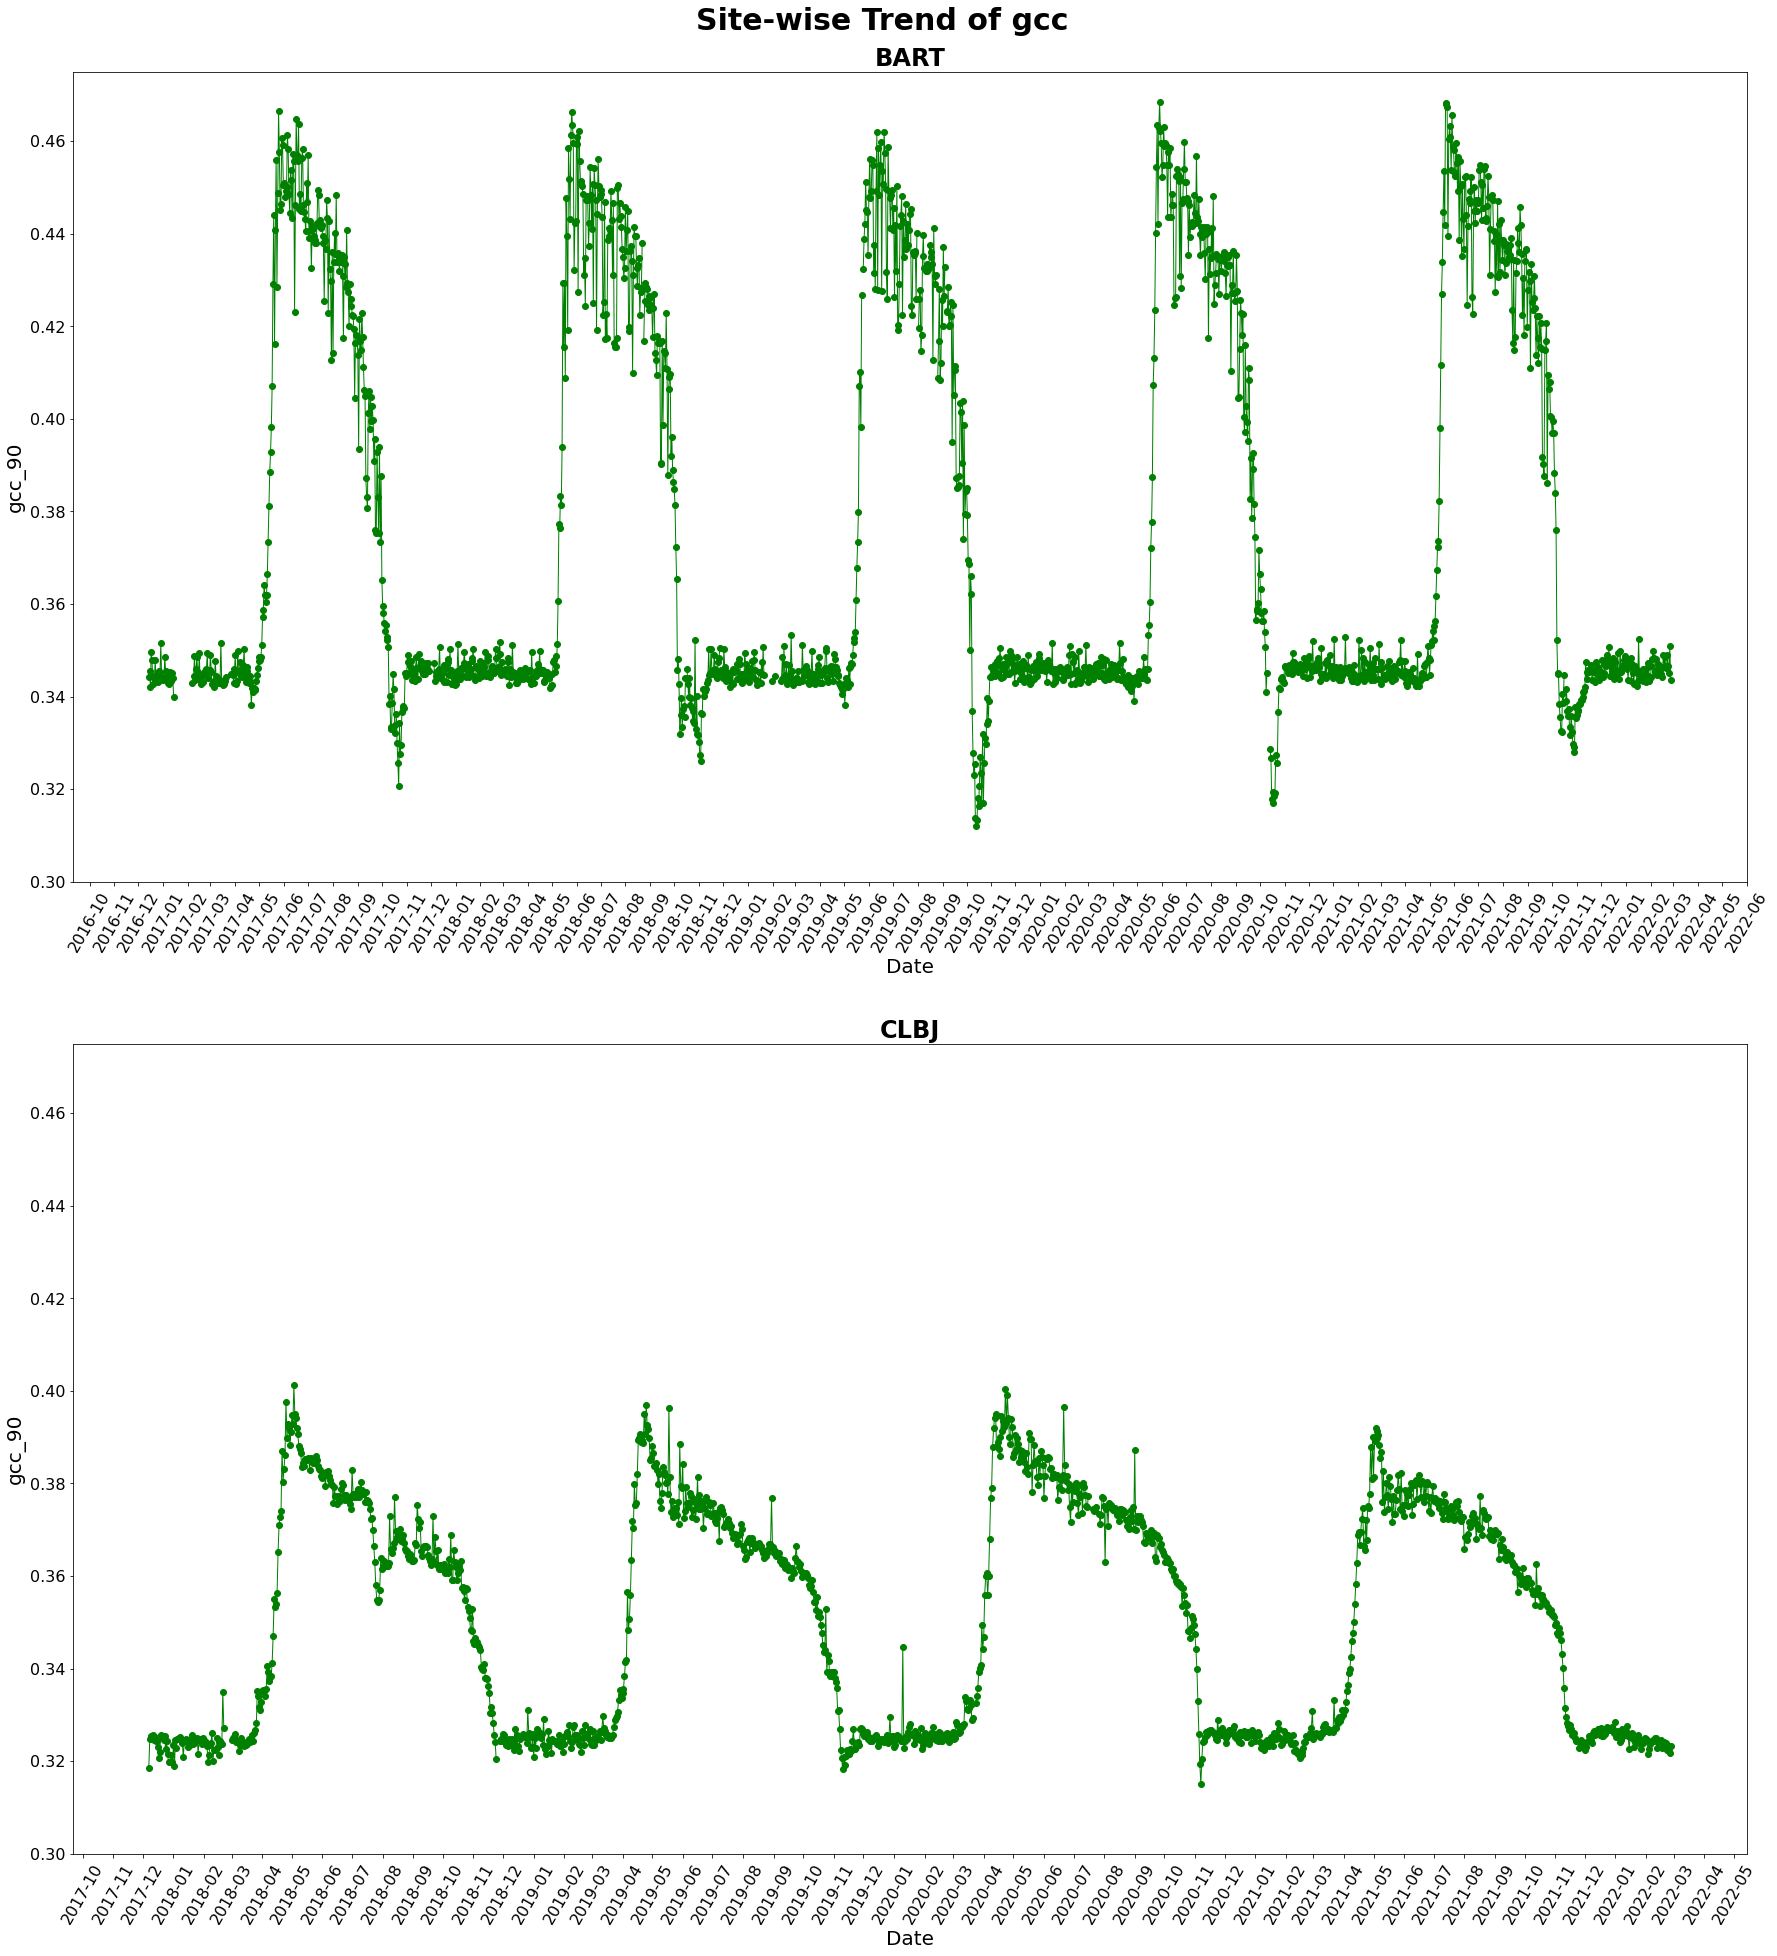

In [8]:
fig, ax = plt.subplots(2, 1, figsize = (30, 30))
ax = ax.flatten()
fig.suptitle("Site-wise Trend of gcc", fontsize=30, fontweight='bold')

for k in range(0,2):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.475)
    ax[k].set_ylabel("gcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

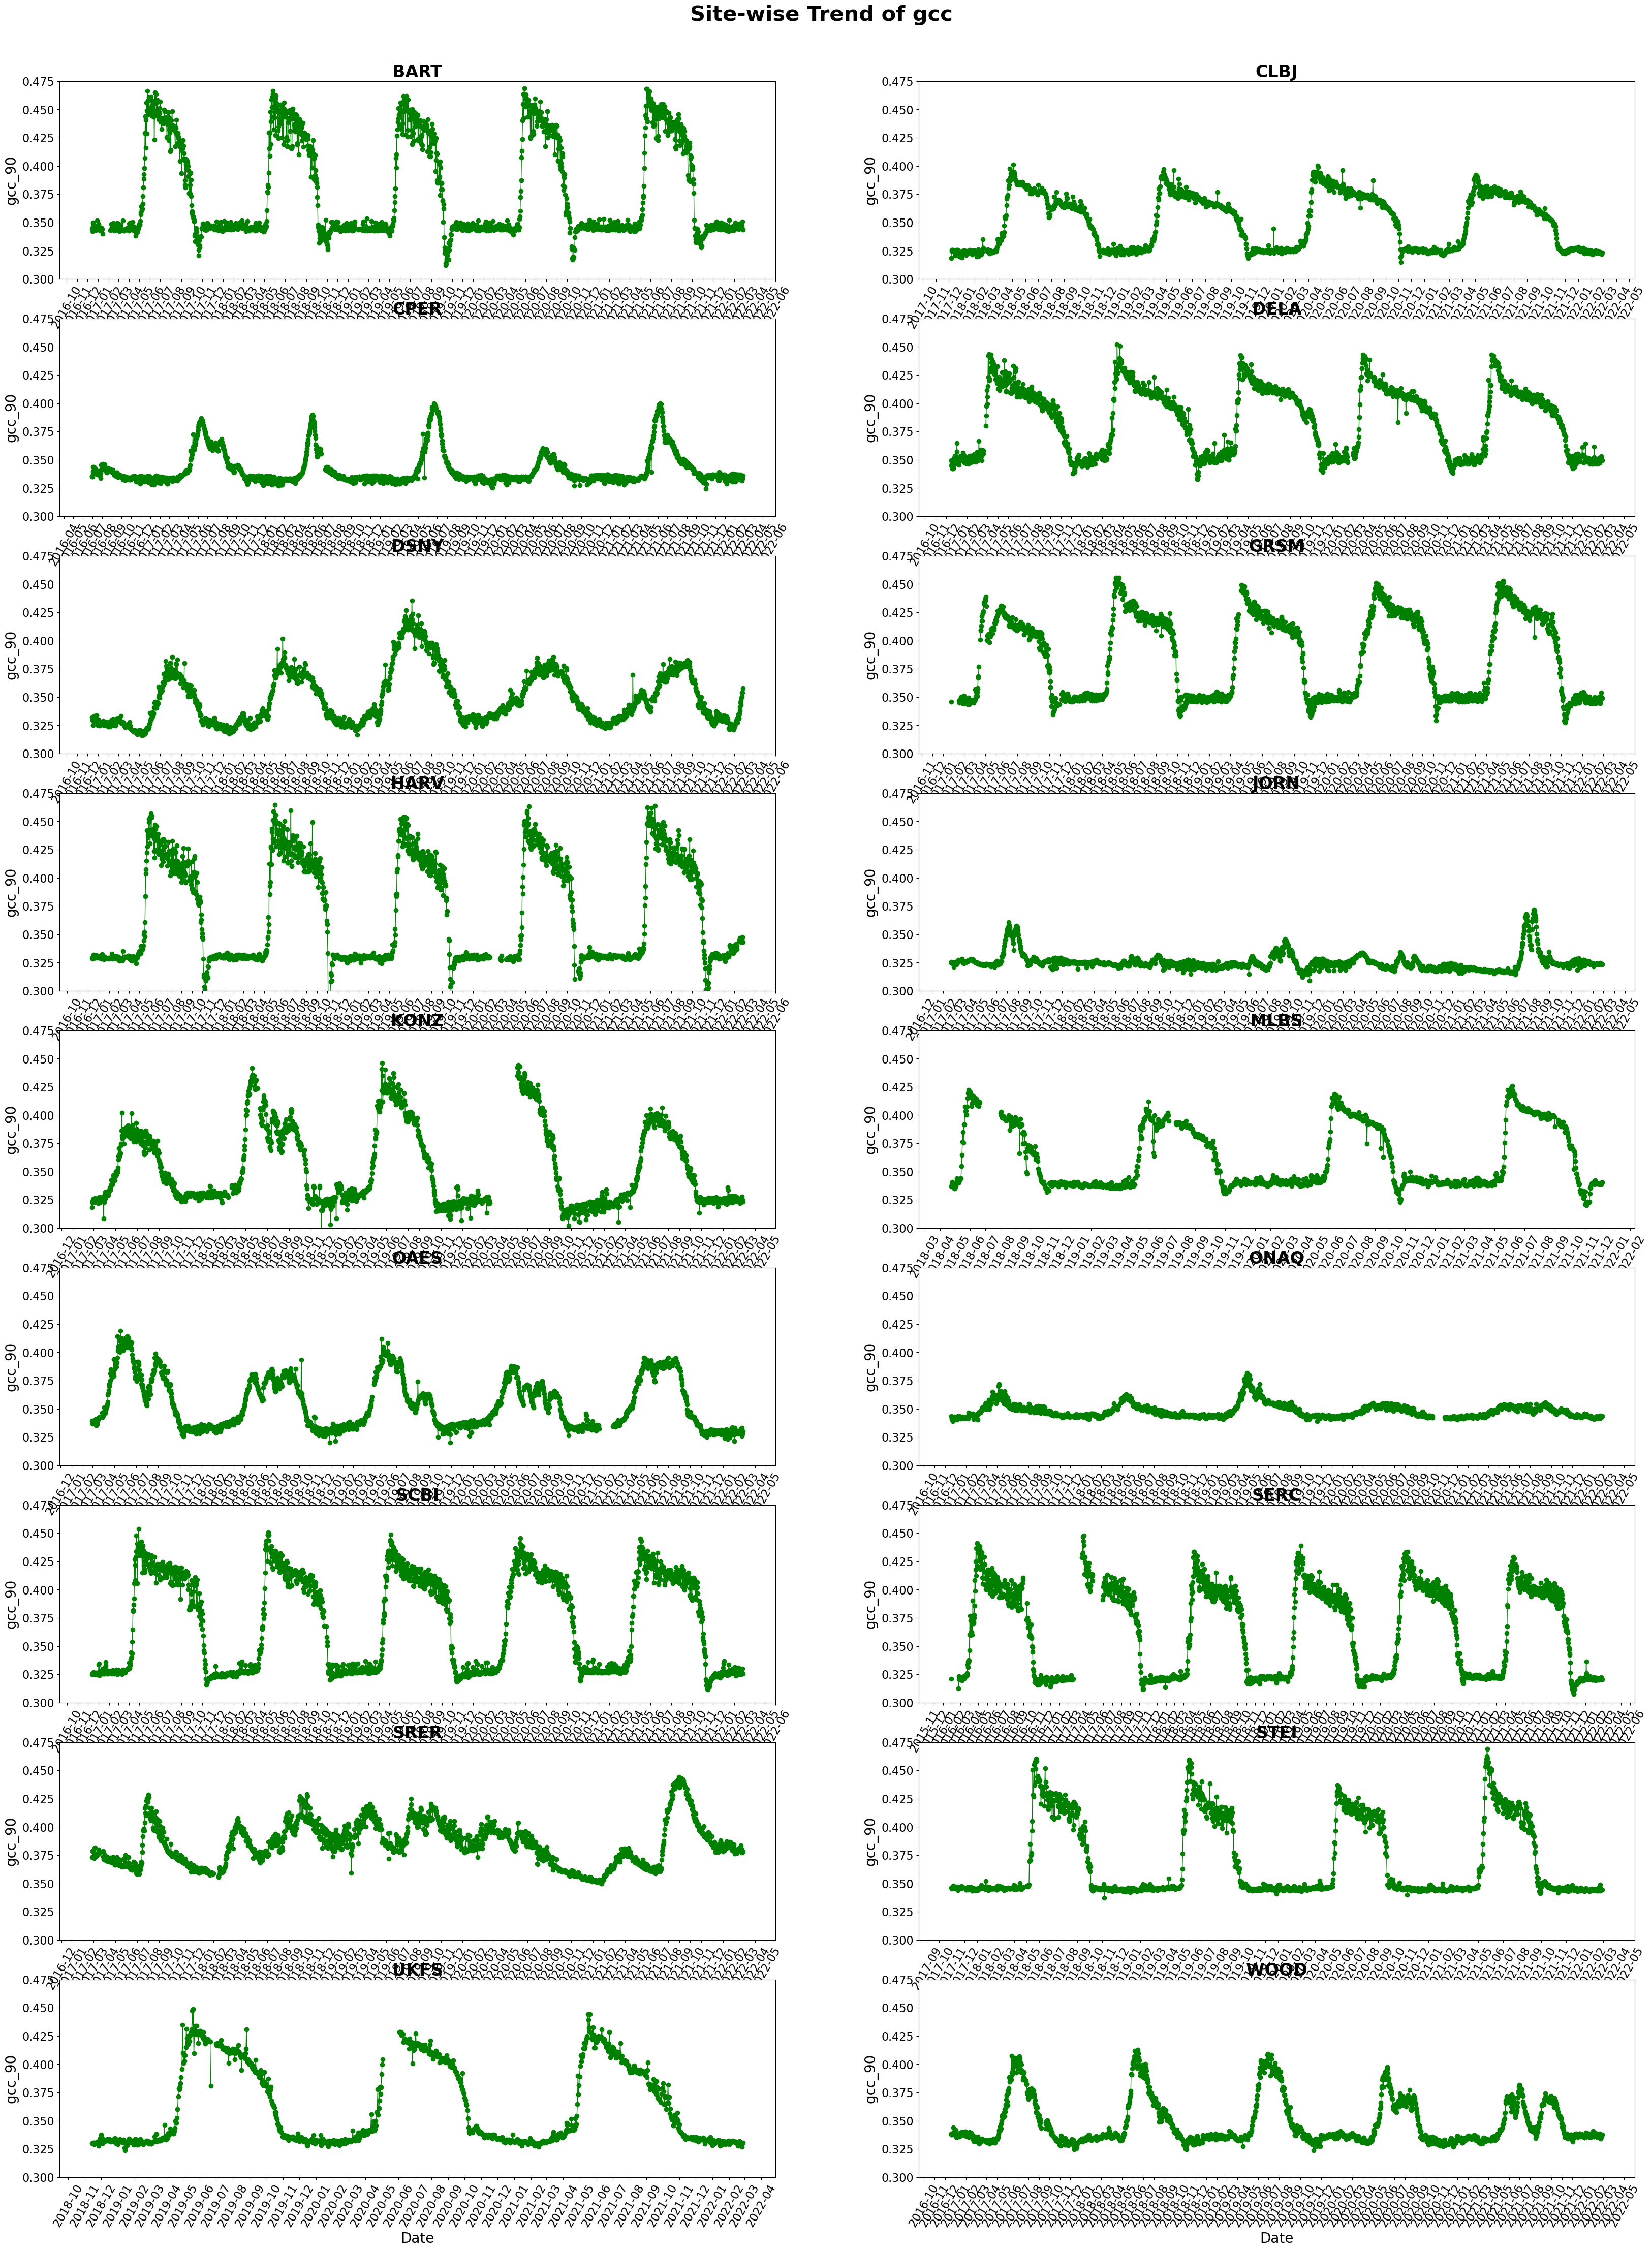

In [9]:
fig, ax = plt.subplots(9, 2, figsize = (40, 50), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of gcc", fontsize=30, fontweight='bold')

for k in range(0,num_sites):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.475)
    ax[k].set_ylabel("gcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

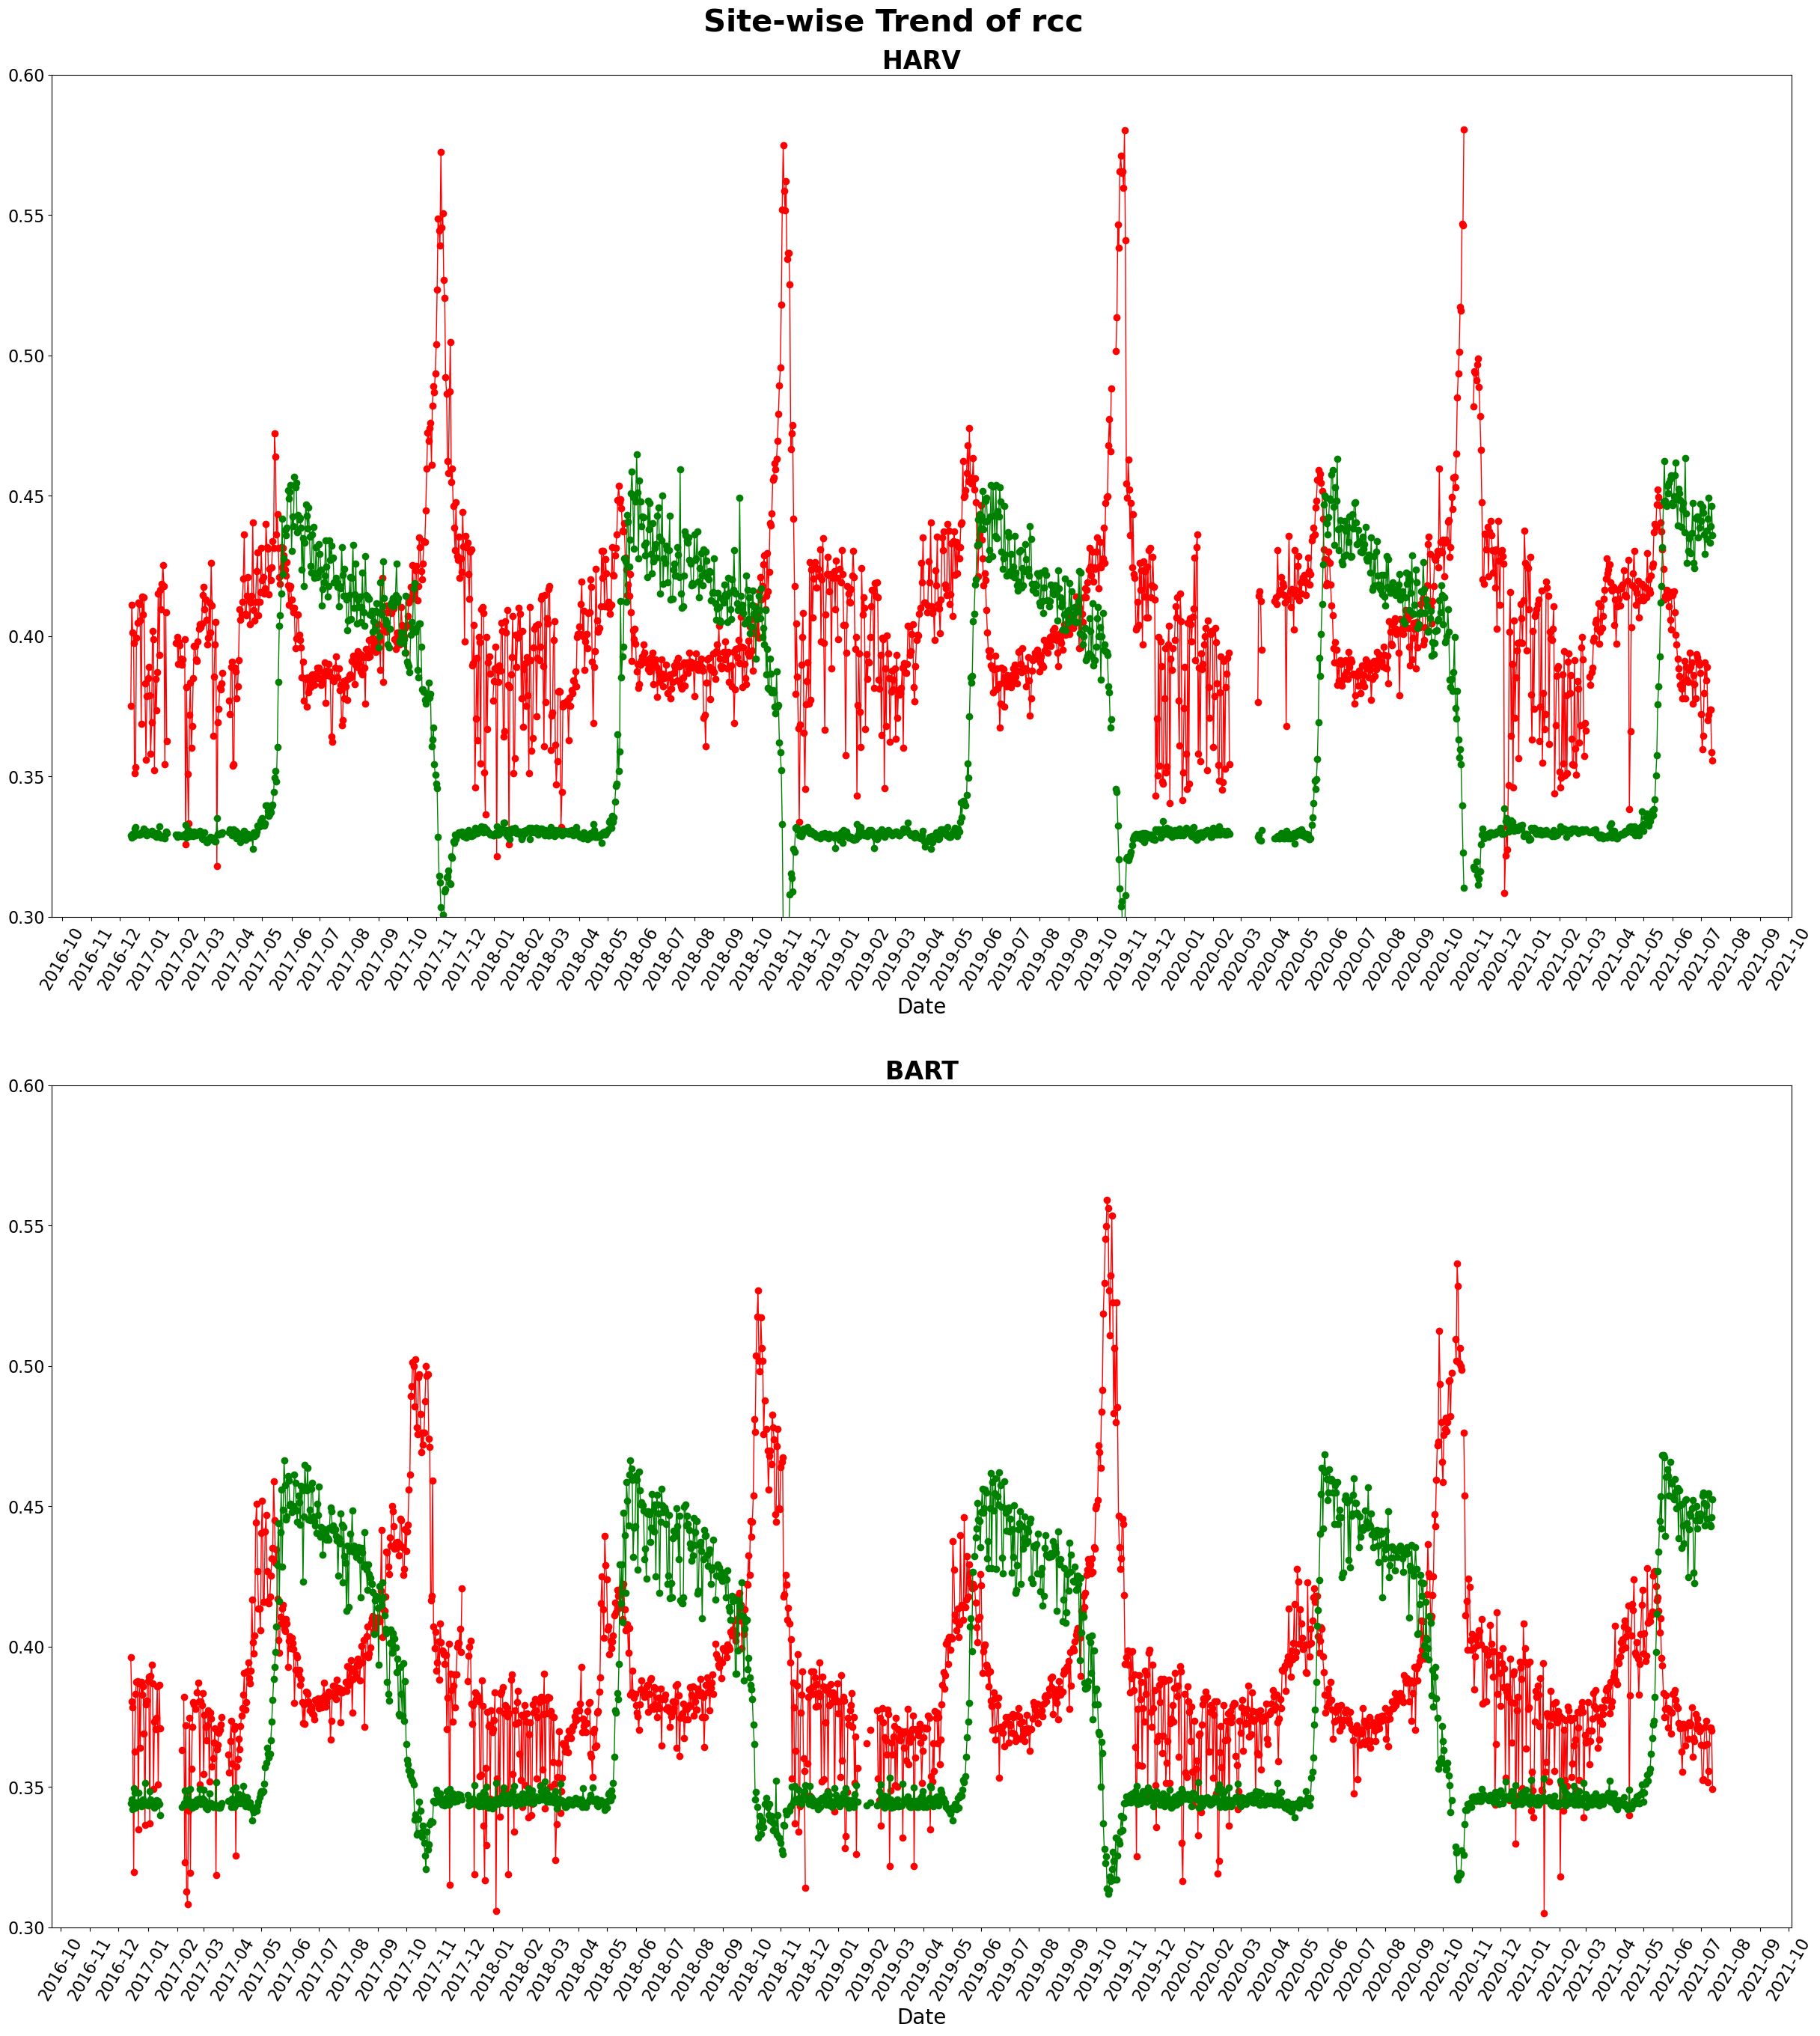

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (30, 30), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of rcc", fontsize=30, fontweight='bold')

for k in range(0,2):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(rcc_site_data[k]["time"], rcc_site_data[k]["rcc_90"], color = 'red', lw=1, marker = 'o', label = "rcc")
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o', label = "gcc")
    ax[k].set_ylim(0.3,0.6)
    #ax[k].set_ylabel("rcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

In [11]:
len(rcc_site_data)

18

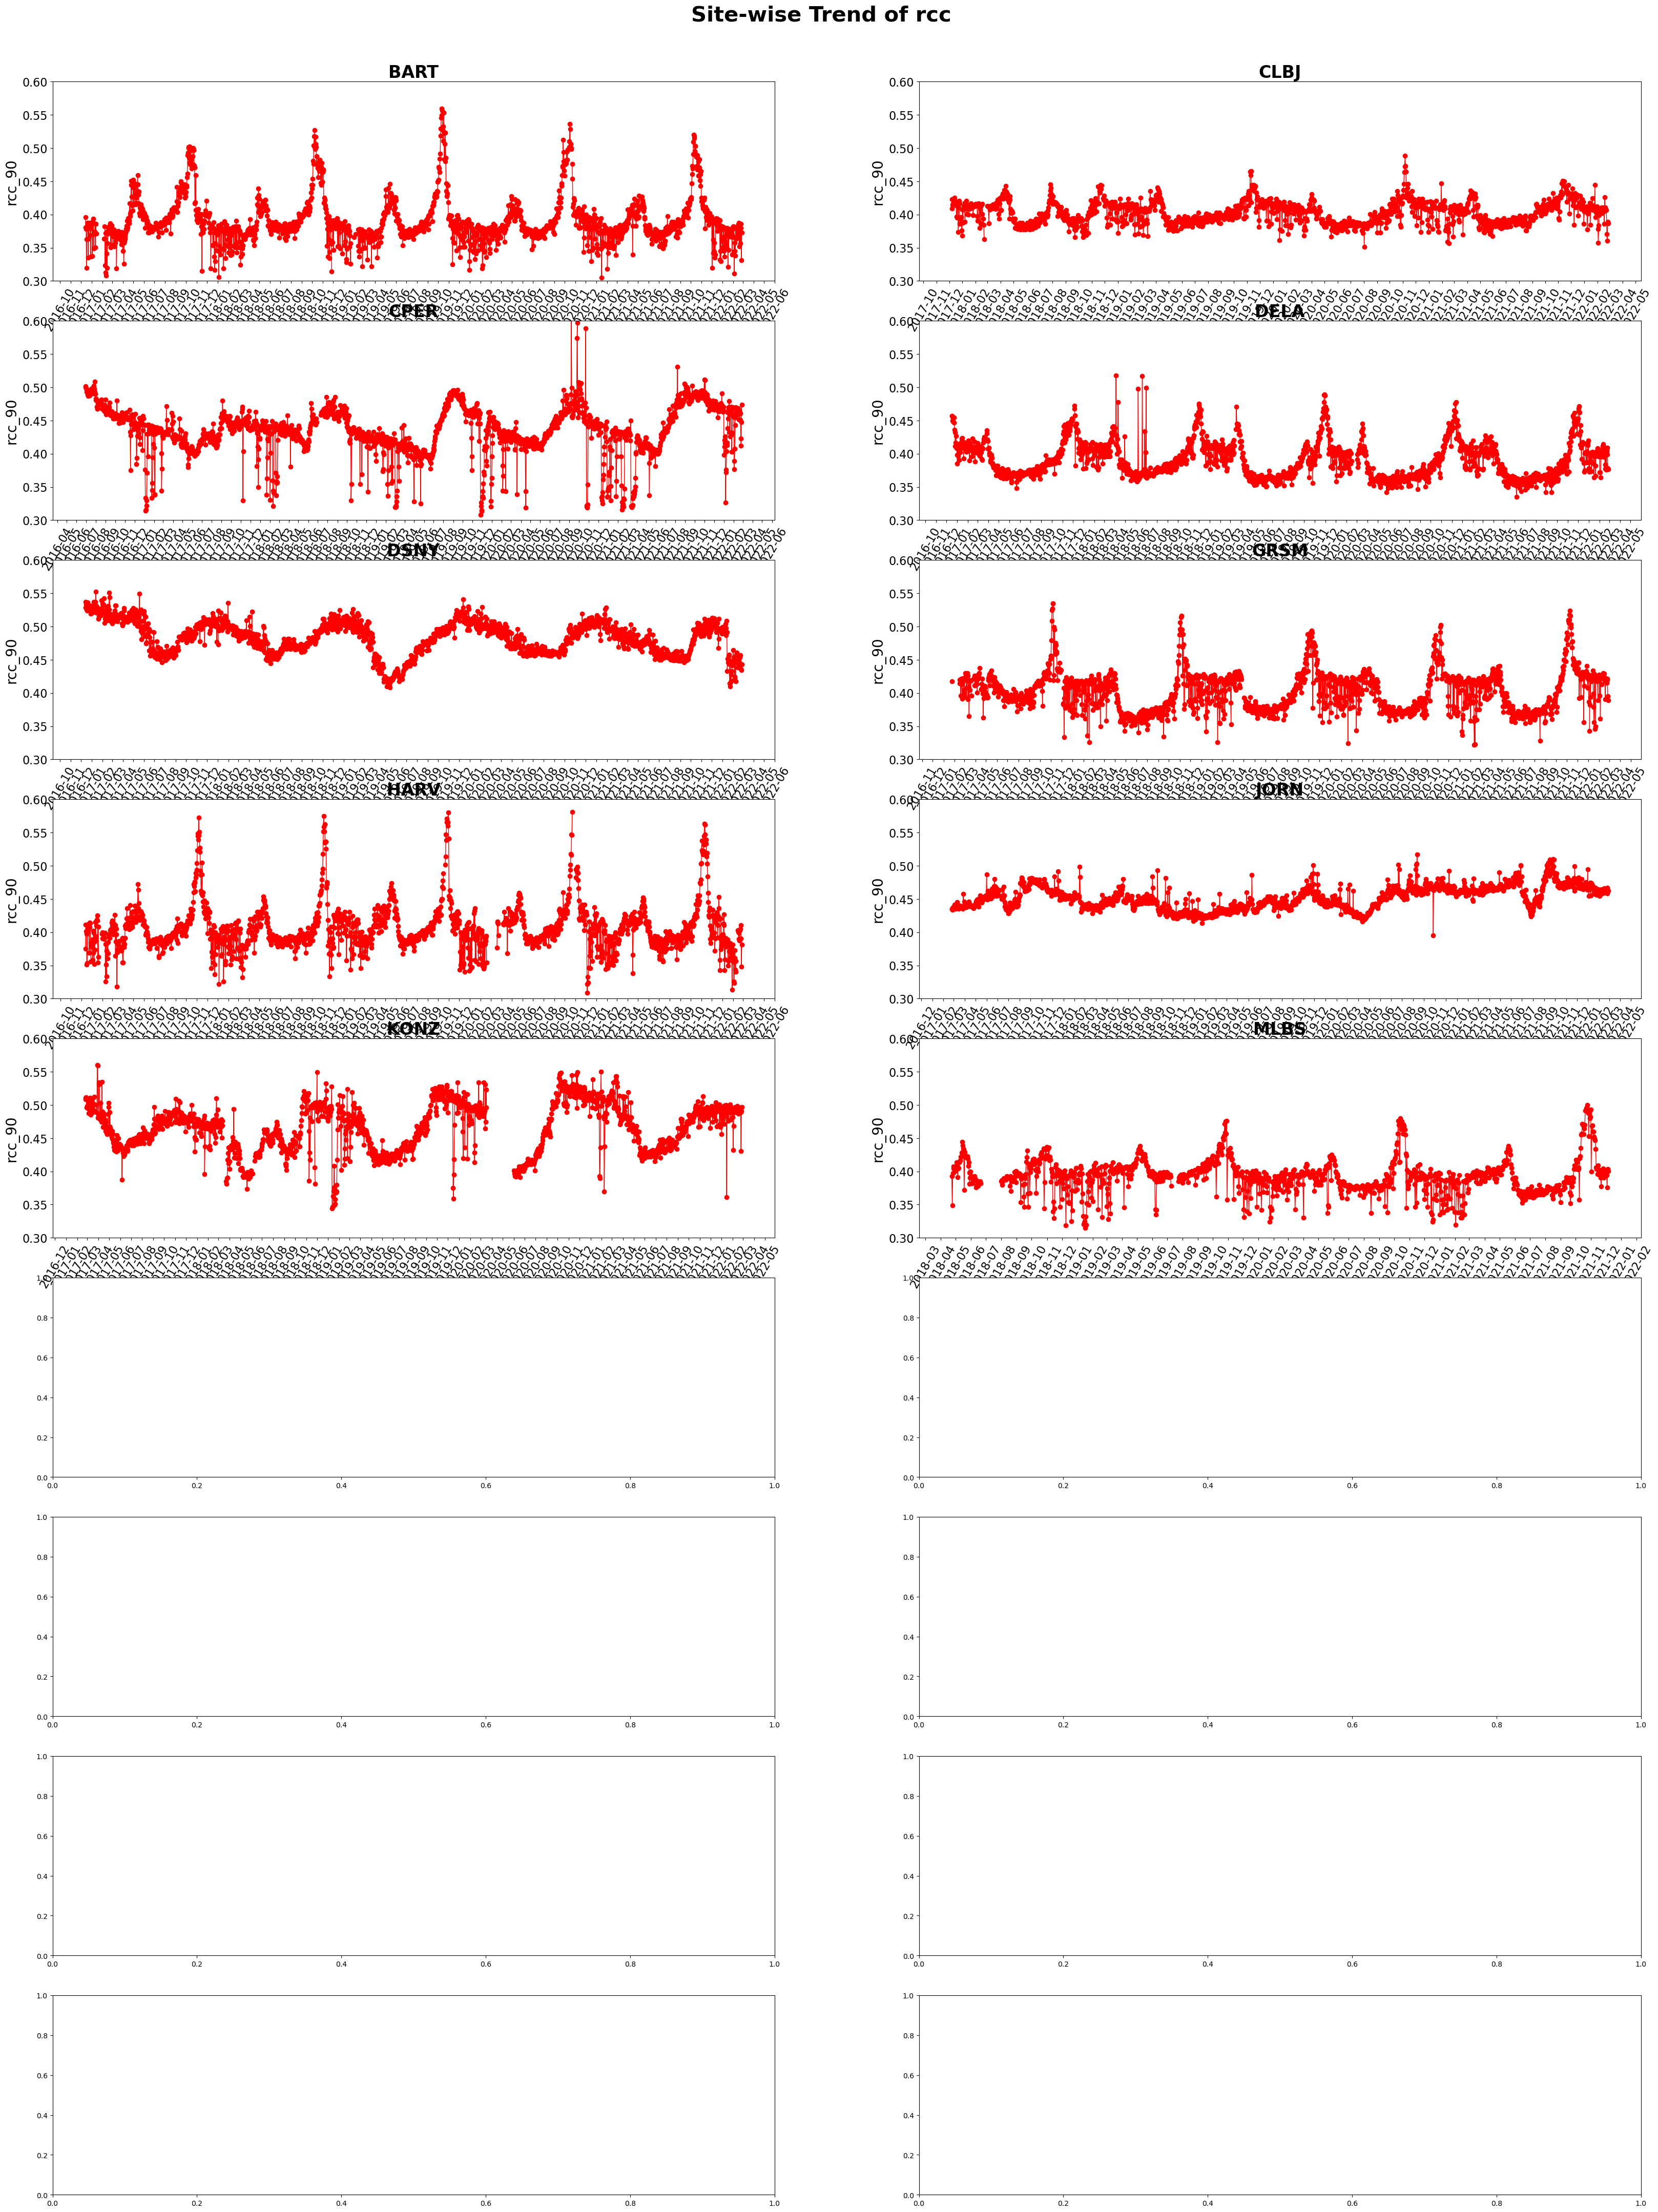

In [12]:
fig, ax = plt.subplots(9, 2, figsize = (40, 50), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of rcc", fontsize=30, fontweight='bold')

for k in range(0,10):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(rcc_site_data[k]["time"], rcc_site_data[k]["rcc_90"], color = 'red', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.6)
    ax[k].set_ylabel("rcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
    
plt.subplots_adjust(top=0.95)

### GCC prediction

In [13]:
#Creating features by using shift() function with gcc dataset

input_features = ['radiation', 'max_temp', 'min_temp', 'precip']
target_variables = ['gcc_90']
for k in range(0,num_sites):
    for i in range(1,11):     #Creating features columns for last 10 days from last year
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        gcc_site_data[k].loc[:,col_name_last_year] = gcc_site_data[k].loc[:,"gcc_90"].shift(i+365)
    for i in range(0,10):     #Creating features columns for t to (t+9) days from last year
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        gcc_site_data[k].loc[:,col_name_last_year_ahead] = gcc_site_data[k].loc[:,"gcc_90"].shift(365-i)

C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
print("Input Features for gcc prediction:\n" + str(input_features))
print("\nTarget Variables for gcc prediction:\n" + str(target_variables))

Input Features for gcc prediction:
['radiation', 'max_temp', 'min_temp', 'precip', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t-6)', 'last_year_gcc_90_(t-7)', 'last_year_gcc_90_(t-8)', 'last_year_gcc_90_(t-9)', 'last_year_gcc_90_(t-10)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)', 'last_year_gcc_90_(t+8)', 'last_year_gcc_90_(t+9)']

Target Variables for gcc prediction:
['gcc_90']


In [15]:
#drop missing values
for k in range(0,num_sites):
    gcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)

# data count for each year after dropping missing values
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,len(site_list)):
    data_count[site_list[k]] =  gcc_site_data[k].groupby("year").count().iloc[:, 1]
data_count

<ipython-input-15-1963cb6052ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)
<ipython-input-15-1963cb6052ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)
<ipython-input-15-1963cb6052ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcc_site_data[k].dropna(subs

BART   CLBJ   CPER   DELA   DSNY   GRSM   HARV   JORN   KONZ   MLBS  \
2016    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017    8.0    NaN  161.0    6.0    8.0    NaN    7.0    NaN    NaN    NaN   
2018  257.0   15.0  256.0  296.0  272.0  221.0  291.0  188.0  236.0    NaN   
2019  284.0  317.0  331.0  361.0  365.0  350.0  341.0  365.0  244.0  180.0   
2020  251.0  357.0  344.0  320.0  354.0  281.0  259.0  357.0  289.0  310.0   
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

       OAES   ONAQ   SCBI   SERC   SRER   STEI   UKFS   WOOD  
2016    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017    NaN    3.0    9.0  165.0    NaN    NaN    NaN    3.0  
2018  227.0  291.0  281.0  218.0  246.0   28.0    NaN  243.0  
2019  317.0  339.0  223.0  324.0  312.0  335.0   38.0  365.0  
2020  288.0  310.0  321.0  327.0  281.0  325.0  231.0  365.0  
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

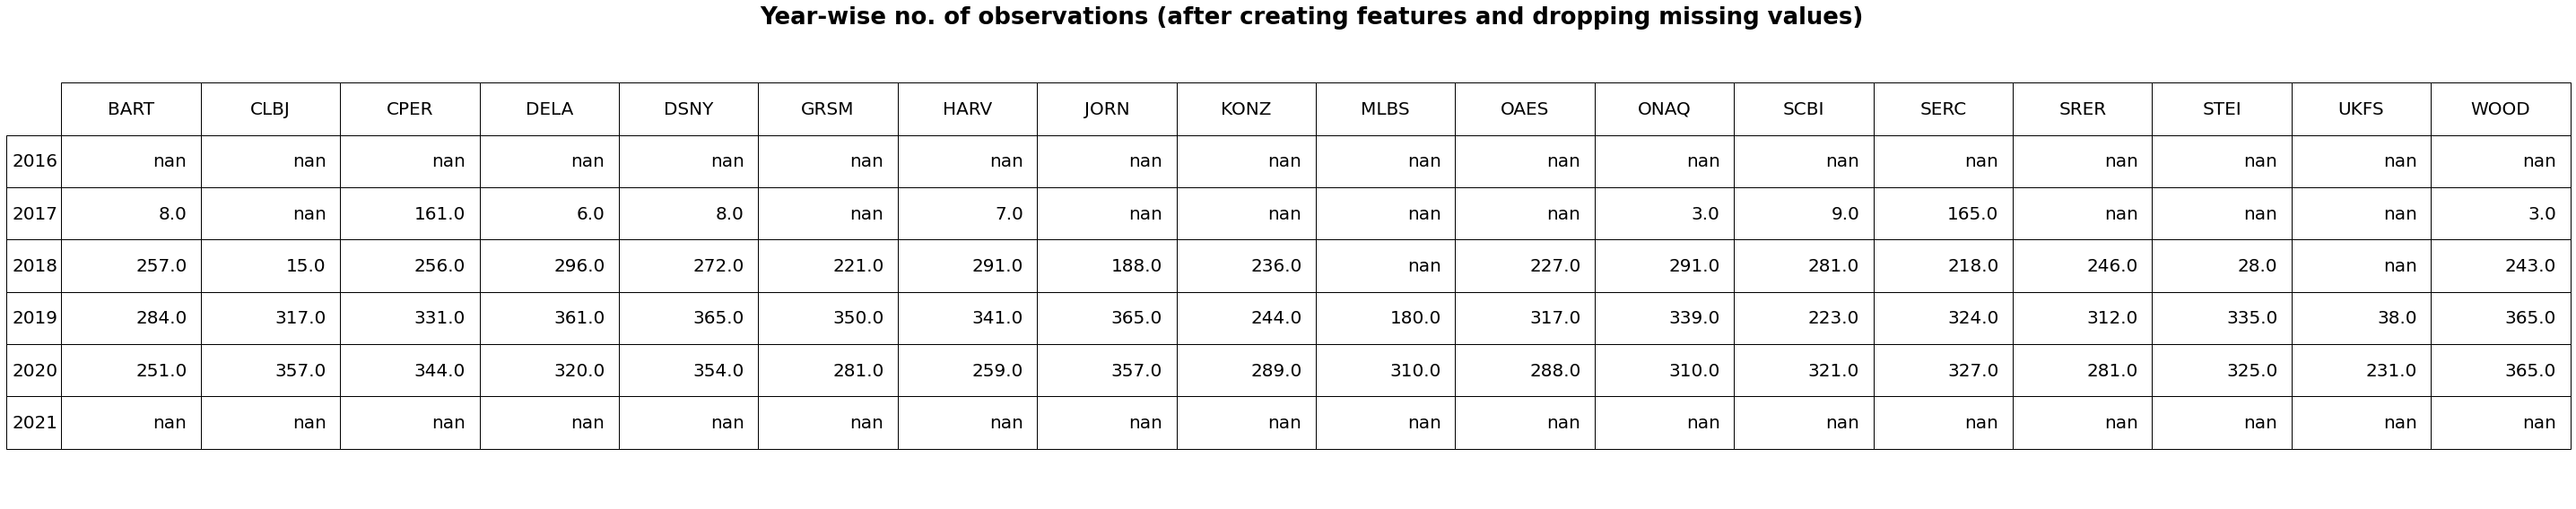

In [16]:
fig = plt.figure(figsize=(40,8))
table = plt.table(np.array(data_count), rowLabels = [2016, 2017, 2018, 2019, 2020, 2021],
                      colLabels = site_list,
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values) ", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()

In [17]:
for k in range(0,num_sites):
    gcc_site_data[k] = gcc_site_data[k].set_index("time")


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)

Best Model:RandomForestRegressor(max_depth=10, max_features=0.1, n_estimators=10)

Best Score:-0.01158014528762069

After 3-fold cross-validation with best parameters RFR: -0.012384 (+/- 0.002161)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.04656803601431996

After 3-fold cross-validation with best parameters SVR: -0.046568 (+/- 0.003343)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='

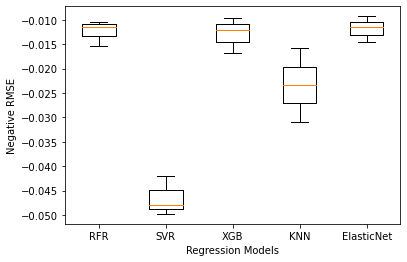


CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)

Best Model:RandomForestRegressor(max_depth=10, max_features=0.4, n_estimators=20)

Best Score:-0.018104910744962607

After 3-fold cross-validation with best parameters RFR: -0.020434 (+/- 0.014464)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.027284106687314038

After 3-fold cross-validation with best parameters SVR: -0.027284 (+/- 0.015711)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

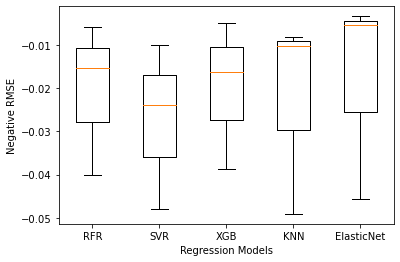


CPER:

Shape of X_train:(748, 24)
Shape of Y_train:(748,)
Shape of X_test:(344, 24)
Shape of Y_test:(344,)

Best Model:RandomForestRegressor(max_depth=12, max_features=0.1, n_estimators=20)

Best Score:-0.013315431606699651

After 3-fold cross-validation with best parameters RFR: -0.014083 (+/- 0.006695)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.021464634533697142

After 3-fold cross-validation with best parameters SVR: -0.021465 (+/- 0.003626)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

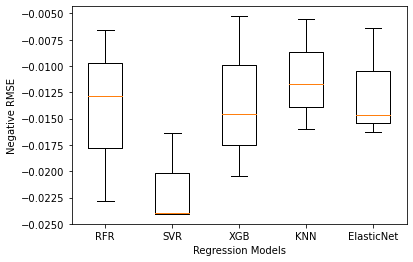


DELA:

Shape of X_train:(663, 24)
Shape of Y_train:(663,)
Shape of X_test:(320, 24)
Shape of Y_test:(320,)

Best Model:RandomForestRegressor(max_depth=13, max_features='sqrt')

Best Score:-0.006712955657037785

After 3-fold cross-validation with best parameters RFR: -0.007013 (+/- 0.001771)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.028000831487537528

After 3-fold cross-validation with best parameters SVR: -0.028001 (+/- 0.001487)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', vali

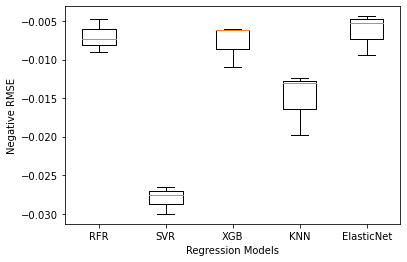


DSNY:

Shape of X_train:(645, 24)
Shape of Y_train:(645,)
Shape of X_test:(354, 24)
Shape of Y_test:(354,)

Best Model:RandomForestRegressor(max_depth=5, max_features=0.3, n_estimators=50)

Best Score:-0.017493047748538576

After 3-fold cross-validation with best parameters RFR: -0.017793 (+/- 0.006724)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.030218316178609136

After 3-fold cross-validation with best parameters SVR: -0.030218 (+/- 0.004988)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=

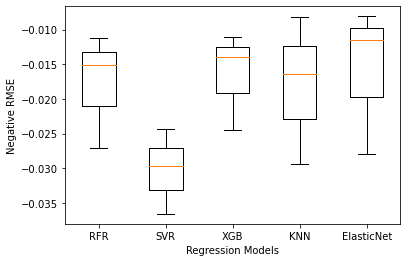


GRSM:

Shape of X_train:(571, 24)
Shape of Y_train:(571,)
Shape of X_test:(281, 24)
Shape of Y_test:(281,)

Best Model:RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=20)

Best Score:-0.008506303777094009

After 3-fold cross-validation with best parameters RFR: -0.010216 (+/- 0.001554)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.03879085531943405

After 3-fold cross-validation with best parameters SVR: -0.038791 (+/- 0.005499)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_meth

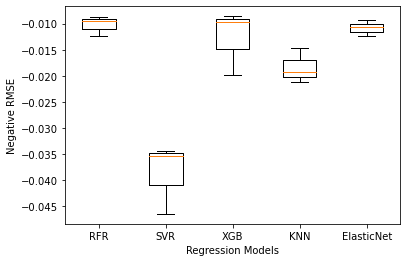


HARV:

Shape of X_train:(639, 24)
Shape of Y_train:(639,)
Shape of X_test:(259, 24)
Shape of Y_test:(259,)

Best Model:RandomForestRegressor(max_depth=13, n_estimators=20)

Best Score:-0.01762225287497524

After 3-fold cross-validation with best parameters RFR: -0.019984 (+/- 0.002651)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.04746251743103543

After 3-fold cross-validation with best parameters SVR: -0.047463 (+/- 0.003532)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_p

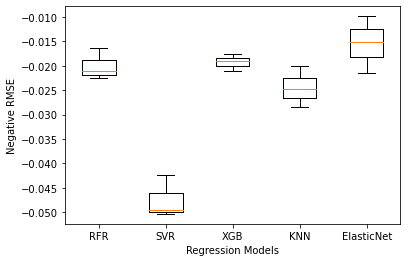


JORN:

Shape of X_train:(553, 24)
Shape of Y_train:(553,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)

Best Model:RandomForestRegressor(max_depth=6, n_estimators=50)

Best Score:-0.004671966013430884

After 3-fold cross-validation with best parameters RFR: -0.004699 (+/- 0.002759)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.005176014622315346

After 3-fold cross-validation with best parameters SVR: -0.005176 (+/- 0.002794)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.30000000000000004, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='e

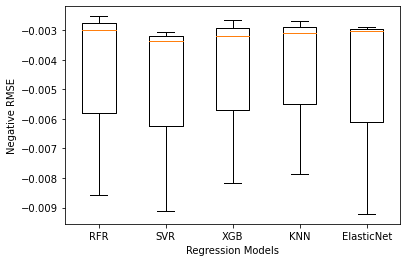


KONZ:

Shape of X_train:(480, 24)
Shape of Y_train:(480,)
Shape of X_test:(289, 24)
Shape of Y_test:(289,)

Best Model:RandomForestRegressor(max_depth=5, max_features=0.1, n_estimators=10)

Best Score:-0.017660385194424404

After 3-fold cross-validation with best parameters RFR: -0.018747 (+/- 0.004823)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.03951015765128003

After 3-fold cross-validation with best parameters SVR: -0.039510 (+/- 0.000995)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='

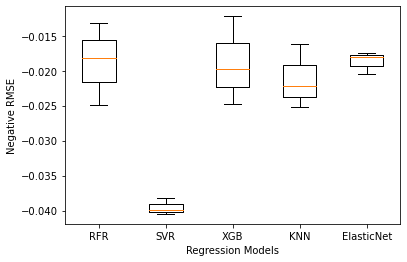


MLBS:

Shape of X_train:(180, 24)
Shape of Y_train:(180,)
Shape of X_test:(310, 24)
Shape of Y_test:(310,)

Best Model:RandomForestRegressor(max_depth=14, max_features=0.2, n_estimators=10)

Best Score:-0.007687239783309425

After 3-fold cross-validation with best parameters RFR: -0.009358 (+/- 0.006637)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.023885874940954645

After 3-fold cross-validation with best parameters SVR: -0.023886 (+/- 0.012786)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

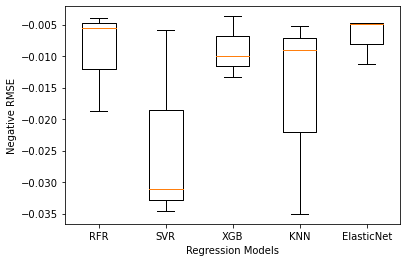


OAES:

Shape of X_train:(544, 24)
Shape of Y_train:(544,)
Shape of X_test:(288, 24)
Shape of Y_test:(288,)

Best Model:RandomForestRegressor(max_depth=8, max_features=0.1, n_estimators=10)

Best Score:-0.015164840528937837

After 3-fold cross-validation with best parameters RFR: -0.016154 (+/- 0.005503)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.0258083576467857

After 3-fold cross-validation with best parameters SVR: -0.025808 (+/- 0.003761)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='e

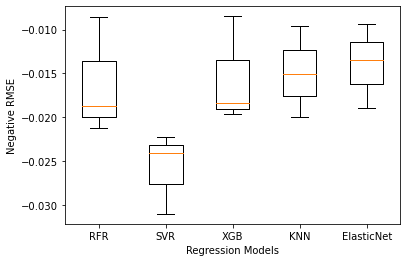


ONAQ:

Shape of X_train:(633, 24)
Shape of Y_train:(633,)
Shape of X_test:(310, 24)
Shape of Y_test:(310,)

Best Model:RandomForestRegressor(max_depth=14, max_features=0.3, n_estimators=10)

Best Score:-0.004126599789646815

After 3-fold cross-validation with best parameters RFR: -0.004517 (+/- 0.001853)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.010091775194690148

After 3-fold cross-validation with best parameters SVR: -0.010092 (+/- 0.002890)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=17,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_metho

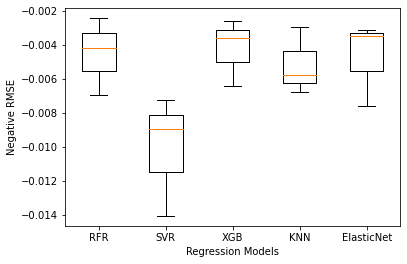


SCBI:

Shape of X_train:(513, 24)
Shape of Y_train:(513,)
Shape of X_test:(321, 24)
Shape of Y_test:(321,)

Best Model:RandomForestRegressor(max_depth=9, max_features=0.1, n_estimators=20)

Best Score:-0.01781027009408911

After 3-fold cross-validation with best parameters RFR: -0.020183 (+/- 0.011161)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.03809199810054492

After 3-fold cross-validation with best parameters SVR: -0.038092 (+/- 0.009788)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='e

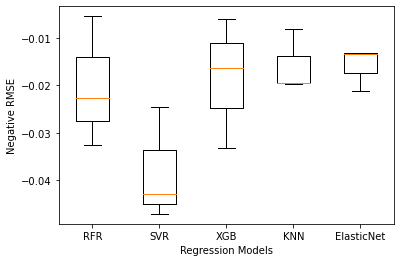


SERC:

Shape of X_train:(707, 24)
Shape of Y_train:(707,)
Shape of X_test:(327, 24)
Shape of Y_test:(327,)

Best Model:RandomForestRegressor(max_depth=12, max_features=0.2, n_estimators=10)

Best Score:-0.010039761090849121

After 3-fold cross-validation with best parameters RFR: -0.010823 (+/- 0.001447)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.039080710896933935

After 3-fold cross-validation with best parameters SVR: -0.039081 (+/- 0.005396)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

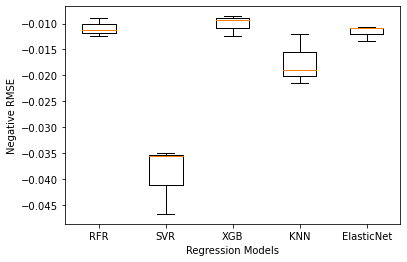


SRER:

Shape of X_train:(558, 24)
Shape of Y_train:(558,)
Shape of X_test:(281, 24)
Shape of Y_test:(281,)

Best Model:RandomForestRegressor(max_depth=12, max_features=0.2, n_estimators=20)

Best Score:-0.015383409292803137

After 3-fold cross-validation with best parameters RFR: -0.016693 (+/- 0.002843)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.013884781667243445

After 3-fold cross-validation with best parameters SVR: -0.013885 (+/- 0.003216)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=

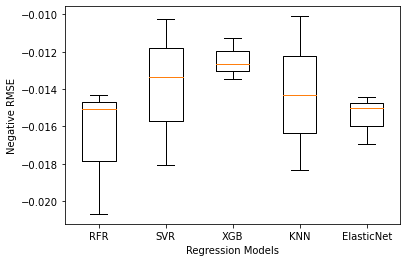


STEI:

Shape of X_train:(363, 24)
Shape of Y_train:(363,)
Shape of X_test:(325, 24)
Shape of Y_test:(325,)

Best Model:RandomForestRegressor(max_depth=8, max_features=0.1, n_estimators=20)

Best Score:-0.026644560854651334

After 3-fold cross-validation with best parameters RFR: -0.027820 (+/- 0.026984)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.04653321109211194

After 3-fold cross-validation with best parameters SVR: -0.046533 (+/- 0.019193)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='

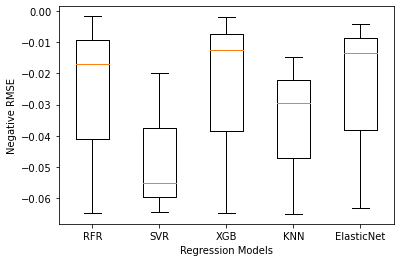


WOOD:

Shape of X_train:(611, 24)
Shape of Y_train:(611,)
Shape of X_test:(365, 24)
Shape of Y_test:(365,)

Best Model:RandomForestRegressor(max_depth=8, max_features=0.1, n_estimators=50)

Best Score:-0.009173406262177967

After 3-fold cross-validation with best parameters RFR: -0.009977 (+/- 0.004065)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.031463294067651214

After 3-fold cross-validation with best parameters SVR: -0.031463 (+/- 0.002529)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=

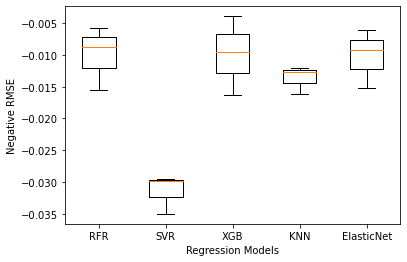

In [18]:
#Evaluating different machine learning algorithms

models = []
#models.append(('SGD', SGDRegressor()))

models.append(('RFR', RandomForestRegressor(), {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]}
              ))

models.append(('SVR', SVR(), {
    'C': [1, 5, 10, 15, 20], 
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001, 0.0001]}
              ))

models.append(('XGB', xgb.XGBRegressor(), {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0,1,11)],
    'max_depth' : [i for i in range(1, 20, 2)]}
              ))

models.append(('KNN', KNeighborsRegressor(), {
    'n_neighbors': [5, 8, 10, 15]}
              ))

models.append(('ElasticNet', ElasticNet(), {
    'alpha' : [0.01,0.001, 0.0001]}
              ))

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc['2020', :]
    Y_test = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc['2020', :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    results = []
    names = []
    for name, model, param_search in models:
        tscv = TimeSeriesSplit(n_splits = 3)
        gsearch = GridSearchCV(model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
        gsearch.fit(X_train, Y_train)
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        print("\nBest Model:" + str(best_model))
        print("\nBest Score:" + str(best_score))
        
        
        cv_results = cross_val_score(best_model, X_train, Y_train, cv = tscv, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        print('\nAfter 3-fold cross-validation with best parameters %s: %f (+/- %f)' % (name, cv_results.mean(), cv_results.std()))
    
    plt.xlabel("Regression Models")
    plt.ylabel("Negative RMSE")
    plt.boxplot(results, labels = names)
    plt.show()

In [19]:
#Train the model using RFR
best_models_RFR = []
overall_rmse_score_RFR = []
overall_r2_score_RFR = []
true_results = []
predicted_results_RFR = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,30,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_RFR.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_RFR.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_RFR.append(rmse)
    overall_r2_score_RFR.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)
RMSE of Training Data: -0.011964886346293334
Model:RandomForestRegressor(max_depth=10, max_features=0.1, n_estimators=10,
                      random_state=0)
explained_variance: 0.9516314828616209
RMSE: 0.009169561130939533
R2: 0.9513492529265722
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)
RMSE of Training Data: -0.019130219589535872
Model:RandomForestRegressor(max_depth=6, random_state=0)
explained_variance: 0.9230837880050096
RMSE: 0.00901879950480237
R2: 0.8737662764077498
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of Y_train:(748,)
Shape of X_test:(344, 24)
Shape of Y_test:(344,)
RMSE of Training Data: -0.013285274138289964
Model:RandomForestRegressor(max_depth=11, max_

In [20]:
#Train the models using XGB
best_models_XGB = []
overall_rmse_score_XGB = []
overall_r2_score_XGB = []
true_results = []
predicted_results_XGB = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = xgb.XGBRegressor(random_state = 100)
    param_search = {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0.1,1,10)],
    'max_depth' : [i for i in range(1, 20)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_XGB.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_XGB.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_XGB.append(rmse)
    overall_r2_score_XGB.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)
RMSE of Training Data: -0.012950722819714348
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
explained_variance: 0.9598116941664476
RMSE: 0.008342626074426393
R2: 0.9597284847884265
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)
RMSE

RMSE of Training Data: -0.015509958786477832
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
explained_variance: 0.7115659234352176
RMSE: 0.00882474460574686
R2: 0.6983165088721308
------------------------------------------------------------------------

ONAQ:

Shape of X_train:(633, 24)
Shape of Y_train:(633,)
Shape of X_test:(310, 24)
Shape of Y_test:(310,)
RMSE of Training Data: -0.004142317909161967
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylev

In [32]:
#Train the models using ElasticNet
best_models_ElasticNet = []
overall_rmse_score_ElasticNet = []
overall_r2_score_ElasticNet = []
true_results = []
predicted_results_ElasticNet = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = ElasticNet(random_state = 100, max_iter = 4000)
    param_search = {
    'alpha': [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
    'l1_ratio': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_ElasticNet.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_ElasticNet.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_ElasticNet.append(rmse)
    overall_r2_score_ElasticNet.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)
RMSE of Training Data: -0.011288638234276283
Model:ElasticNet(alpha=0.001, l1_ratio=0.001, max_iter=4000, random_state=100)
explained_variance: 0.9669392682844812
RMSE: 0.007635907898606487
R2: 0.9662624317459749
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)
RMSE of Training Data: -0.006741276696439094
Model:ElasticNet(alpha=1e-06, max_iter=4000, random_state=100)
explained_variance: 0.9402398407997807
RMSE: 0.00833965435609743
R2: 0.8920620834200782
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of Y_train:(748,)
Shape of X_test:(344, 24)
Shape of Y_test:(344,)
RMSE of Training Data: -0.011760822626805447
Model:ElasticNet(alpha=0.0001, l1_ratio=0.1, max_iter=4000, random_state=100

In [21]:
#Train the models using KNN Regressor
best_models_KNN = []
overall_rmse_score_KNN = []
overall_r2_score_KNN = []
true_results = []
predicted_results_KNN = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = gcc_site_data[k][gcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(gcc_site_data[k][gcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    model = KNeighborsRegressor()
    param_search = {
    'n_neighbors': [5, 8, 10, 12, 15],
    'weights': ['uniform', 'distance']
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_KNN.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_KNN.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_KNN.append(rmse)
    overall_r2_score_KNN.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)
RMSE of Training Data: -0.02316133117712486
Model:KNeighborsRegressor(n_neighbors=12)
explained_variance: 0.7946384437892067
RMSE: 0.019136453292570892
R2: 0.7881076328415896
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)
RMSE of Training Data: -0.022472765331654848
Model:KNeighborsRegressor(n_neighbors=10)
explained_variance: 0.6772589586116431
RMSE: 0.01485030659135167
R2: 0.6577458141802519
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of Y_train:(748,)
Shape of X_test:(344, 24)
Shape of Y_test:(344,)
RMSE of Training Data: -0.010992289449054697
Model:KNeighborsRegressor(n_neighbors=8, weights='distance')
explained_variance: 0.3908245511068199
RMSE: 0.006470197200789446
R2: 0.28

In [23]:
site_list

array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI',
       'UKFS', 'WOOD'], dtype=object)

In [28]:
site_list_modified = np.array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI','WOOD'])
site_list_modified

array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI',
       'WOOD'], dtype='<U4')

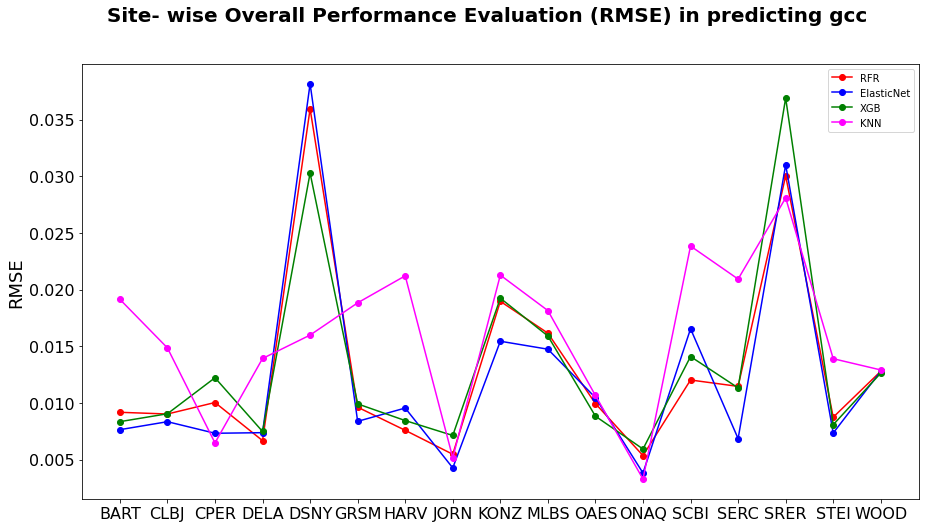

In [33]:
plt.figure(figsize = (15,8))
plt.suptitle("Site- wise Overall Performance Evaluation (RMSE) in predicting gcc", fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel("RMSE", fontsize = 18)
plt.plot(site_list_modified, overall_rmse_score_RFR, color = 'r', marker='o', label = "RFR")
plt.plot(site_list_modified, overall_rmse_score_ElasticNet, color = 'b', marker='o', label = "ElasticNet")
plt.plot(site_list_modified, overall_rmse_score_XGB, color = 'g', marker='o', label = "XGB")
plt.plot(site_list_modified, overall_rmse_score_KNN, color = 'magenta', marker='o', label = "KNN")

plt.legend()

<ipython-input-34-826d00baef72>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  f = pd.datetime(2020,7,1)


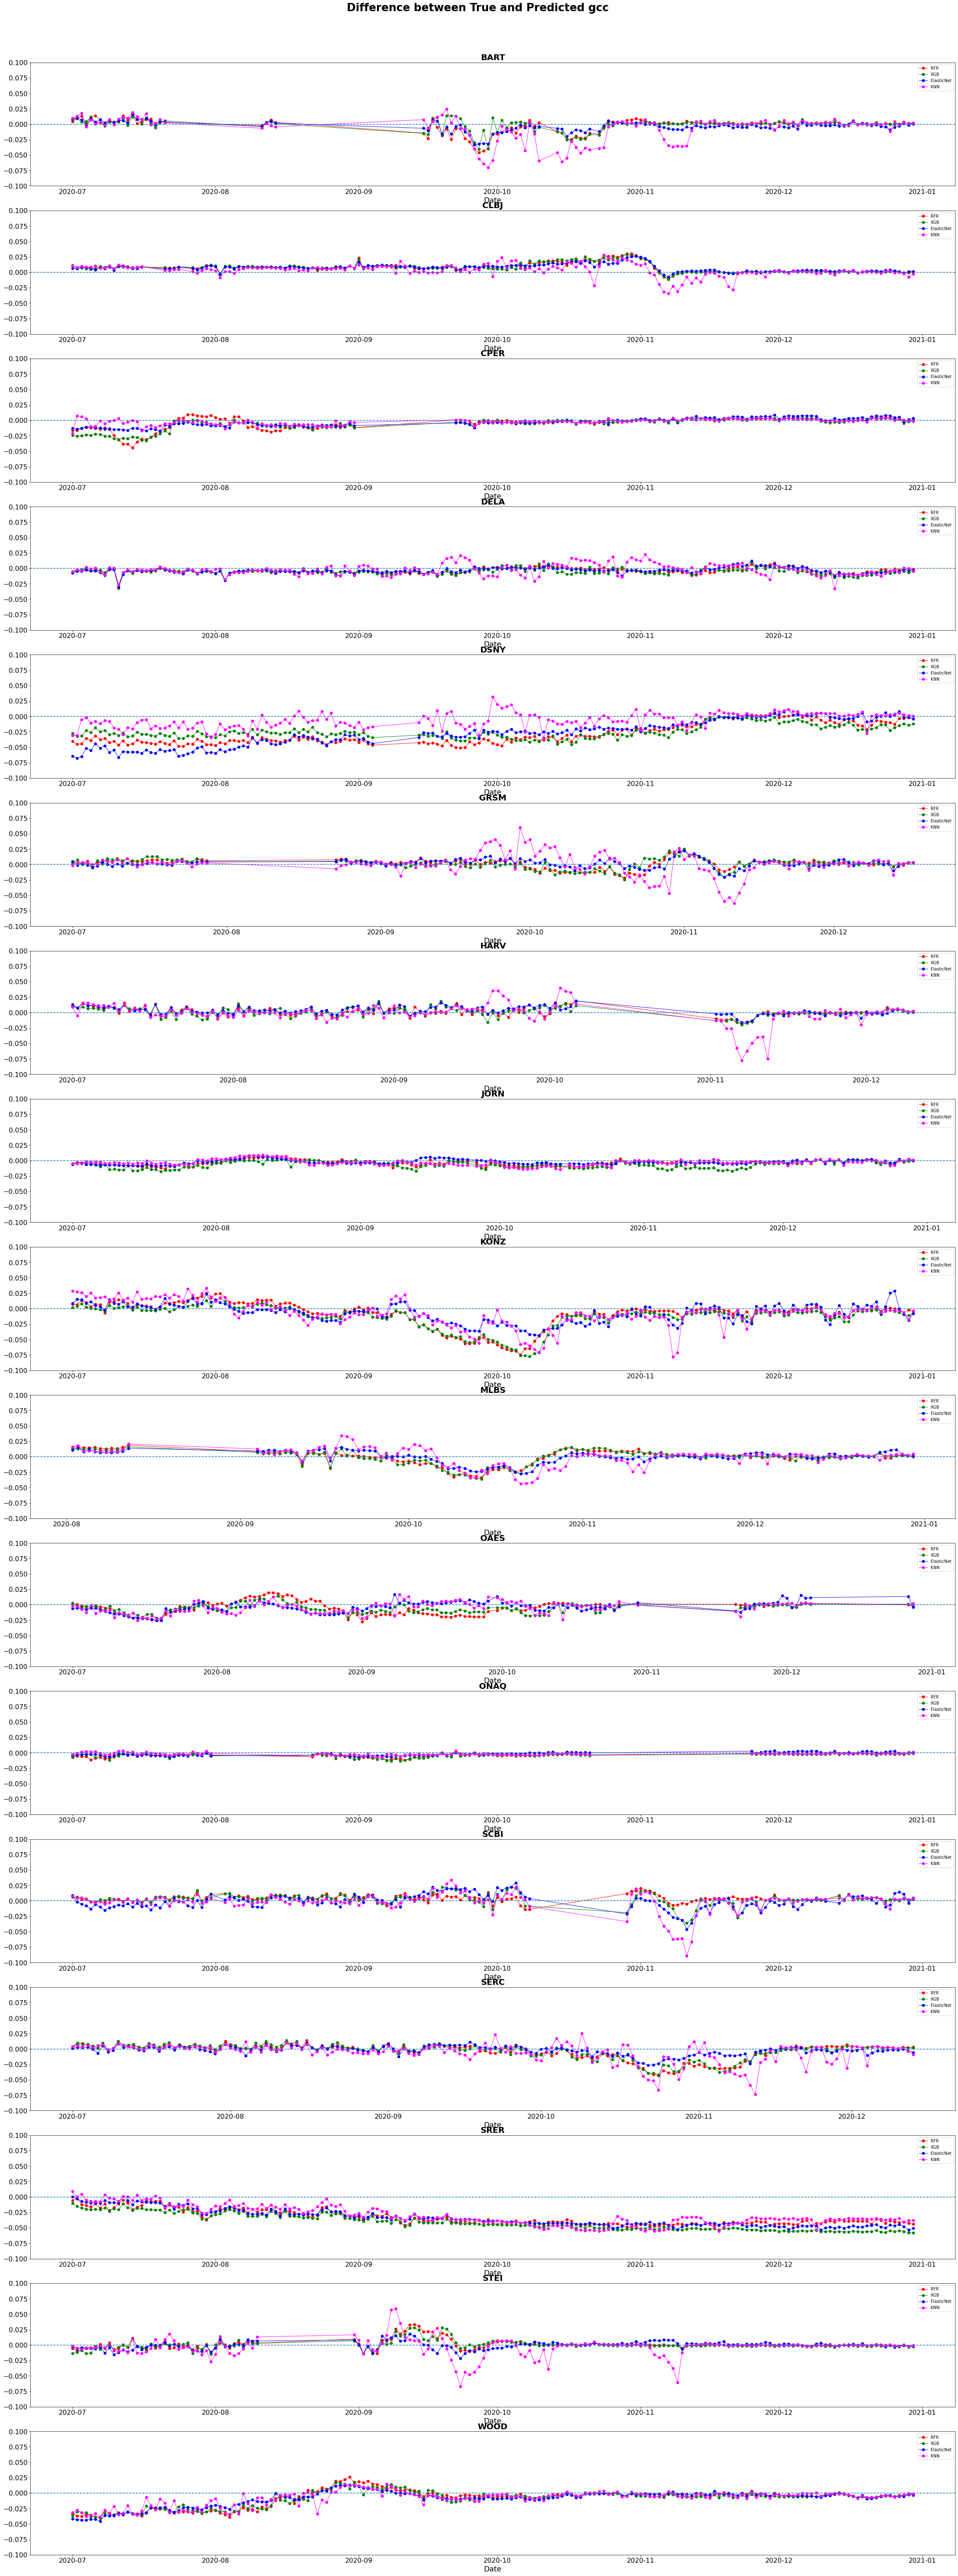

In [34]:
predicted_site_data = []
for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    predicted_site_data.append(gcc_site_data[k].loc['2020', :])

for k in range(0,num_sites-1):
    Y_pred_RFR = predicted_results_RFR[k]
    Y_pred_XGB = predicted_results_XGB[k]
    Y_pred_EN = predicted_results_ElasticNet[k]
    Y_pred_KNN = predicted_results_KNN[k]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_RFR", value = Y_pred_RFR)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_XGB", value = Y_pred_XGB)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_EN", value = Y_pred_EN)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_KNN", value = Y_pred_KNN)

    
f = pd.datetime(2020,7,1)

fig, ax = plt.subplots(17, 1, figsize = (40, 100))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc", fontsize=26, fontweight='bold')
for k in range(0,num_sites-1):
    df = predicted_site_data[k]
    df = df.reset_index()
    df = df.loc[df['time'] >= f]
    ax[k].set_title(site_list_modified[k], fontsize=20, fontweight='bold')
    ax[k].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90_RFR"], color = 'red', lw=1, marker = 'o', label = 'RFR')
    ax[k].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90_XGB"], color = 'green', lw=1, marker = 'o', label = 'XGB')
    ax[k].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90_EN"], color = 'blue', lw=1, marker = 'o', label = 'ElasticNet')
    ax[k].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90_KNN"], color = 'magenta', lw=1, marker = 'o', label = 'KNN')
    ax[k].set_xlabel("Date", fontsize = 18) 
    ax[k].set_ylim(-0.1,0.1)
    ax[k].axhline(y=0, linestyle = '--')
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)
    ax[k].legend()
plt.subplots_adjust(top=0.96)

In [35]:
for k in range(0,num_sites-1):
    df = predicted_site_data[k][["predicted_gcc_90_RFR", "predicted_gcc_90_XGB", "predicted_gcc_90_EN", "predicted_gcc_90_KNN"]]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_mean", 
                                 value = df.mean(axis=1))
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_std", 
                                  value = df.std(axis=1))

In [36]:
for k in range(0,num_sites-1):
    df = predicted_site_data[k][["predicted_gcc_90_RFR", "predicted_gcc_90_XGB", "predicted_gcc_90_EN"]]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_mean_wo_KNN", 
                                 value = df.mean(axis=1))
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90_std_wo_KNN", 
                                  value = df.std(axis=1))

In [37]:
rmse_modified = []
for k in range(0,num_sites-1):
    y_pred = np.array(predicted_site_data[k]["predicted_gcc_90_mean"])
    y_true = np.array(predicted_site_data[k]["gcc_90"])
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    
    rmse_modified.append(rmse)
    
    print("\n" + str(site_list_modified[k]) + ":\n")
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

explained_variance: 0.9462647650745956
RMSE: 0.009710017190338285
R2: 0.9454452699898861
------------------------------------------------------------------------

CLBJ:

explained_variance: 0.9184066027258461
RMSE: 0.008886221608690835
R2: 0.8774503126057759
------------------------------------------------------------------------

CPER:

explained_variance: 0.1762694356841592
RMSE: 0.008050591968767404
R2: -0.10371961902932547
------------------------------------------------------------------------

DELA:

explained_variance: 0.9396104288752991
RMSE: 0.007262523259550577
R2: 0.9329901582315234
------------------------------------------------------------------------

DSNY:

explained_variance: 0.12024211050703881
RMSE: 0.02852872110607228
R2: -1.6736789181925698
------------------------------------------------------------------------

GRSM:

explained_variance: 0.9405117963086123
RMSE: 0.009475257702237819
R2: 0.9371951816159371
--------------------------------------------------

In [38]:
rmse_modified_wo_KNN = []
for k in range(0,num_sites-1):
    y_pred = np.array(predicted_site_data[k]["predicted_gcc_90_mean_wo_KNN"])
    y_true = np.array(predicted_site_data[k]["gcc_90"])
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    
    rmse_modified_wo_KNN.append(rmse)
    
    print("\n" + str(site_list_modified[k]) + ":\n")
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

explained_variance: 0.9648245652061028
RMSE: 0.007810895804835387
R2: 0.964698423366251
------------------------------------------------------------------------

CLBJ:

explained_variance: 0.9324799461111262
RMSE: 0.00869642321470977
R2: 0.8826294169978238
------------------------------------------------------------------------

CPER:

explained_variance: -0.10725006264817916
RMSE: 0.009275205332845433
R2: -0.46504240876269587
------------------------------------------------------------------------

DELA:

explained_variance: 0.9495986638400304
RMSE: 0.0068924740402941925
R2: 0.9396449244436648
------------------------------------------------------------------------

DSNY:

explained_variance: -0.16203790135054352
RMSE: 0.034080938295471
R2: -2.815642968832246
------------------------------------------------------------------------

GRSM:

explained_variance: 0.95246417718745
RMSE: 0.008579842676787845
R2: 0.9485044676444047
-----------------------------------------------------

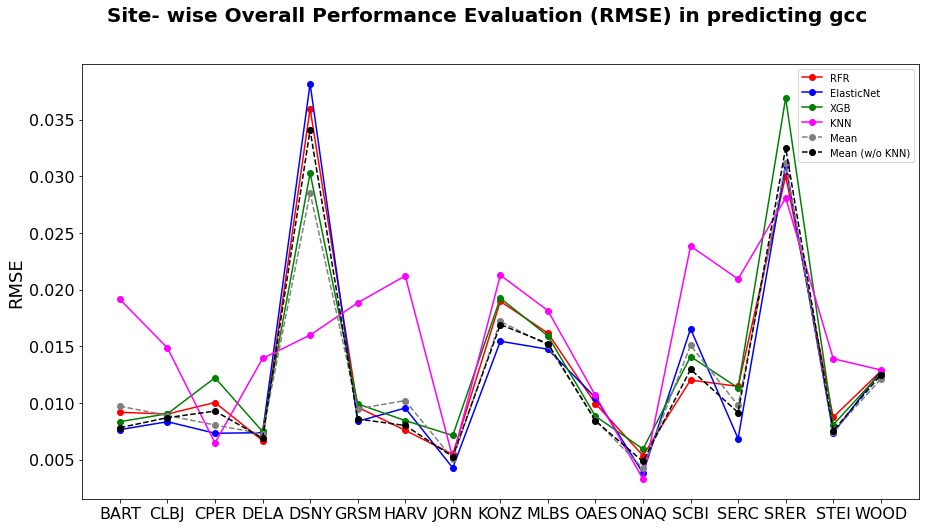

In [39]:
plt.figure(figsize = (15,8))
plt.suptitle("Site- wise Overall Performance Evaluation (RMSE) in predicting gcc", fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel("RMSE", fontsize = 18)
plt.plot(site_list_modified, overall_rmse_score_RFR, color = 'r', marker='o', label = "RFR")
plt.plot(site_list_modified, overall_rmse_score_ElasticNet, color = 'b', marker='o', label = "ElasticNet")
plt.plot(site_list_modified, overall_rmse_score_XGB, color = 'g', marker='o', label = "XGB")
plt.plot(site_list_modified, overall_rmse_score_KNN, color = 'magenta', marker='o', label = "KNN")
plt.plot(site_list_modified, rmse_modified, color = 'gray', marker='o', linestyle = '--', label = "Mean")
plt.plot(site_list_modified, rmse_modified_wo_KNN, color = 'black', marker='o', linestyle = '--', label = "Mean (w/o KNN)")
plt.legend()

#### Final decision is to take average of the three models: RFR, ElasticNet and XGB. Now, UKFS is trained with these three models for the future predictions without validation

In [40]:
#Train RFR model for UKFS and update best_models_RFR list

UKFS_X_train = gcc_site_data[4][gcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(gcc_site_data[4][gcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))
 
model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,30,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_RFR.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.025647032455564284
Model:RandomForestRegressor(max_depth=5, max_features=0.3, n_estimators=10,
                      random_state=0)


In [41]:
#Train the UKFS models using XGB

UKFS_X_train = gcc_site_data[4][gcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(gcc_site_data[4][gcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))

model = xgb.XGBRegressor(random_state = 100)
param_search = {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0.1,1,10)],
    'max_depth' : [i for i in range(1, 20)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_XGB.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.02176374849099642
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [42]:
#Train the models using ElasticNet

UKFS_X_train = gcc_site_data[4][gcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(gcc_site_data[4][gcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))

model = ElasticNet(random_state = 100, max_iter = 4000)
param_search = {
    'alpha': [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
    'l1_ratio': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_ElasticNet.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.018694080419842184
Model:ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=4000, random_state=100)


In [44]:
site_list_modified

array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI',
       'WOOD'], dtype='<U4')

In [46]:
#Added the site "UKFS" at the end
site_list_modified = np.append(site_list_modified, "UKFS")
print(site_list_modified)

['BART' 'CLBJ' 'CPER' 'DELA' 'DSNY' 'GRSM' 'HARV' 'JORN' 'KONZ' 'MLBS'
 'OAES' 'ONAQ' 'SCBI' 'SERC' 'SRER' 'STEI' 'WOOD' 'UKFS']


In [47]:
for k in range(0,num_sites):
    pickle.dump(best_models_RFR[k], open("PEG_FUSION_0_gcc_model_RFR_"+site_list_modified[k]+".pkl", 'wb'))
    pickle.dump(best_models_XGB[k], open("PEG_FUSION_0_gcc_model_XGB_"+site_list_modified[k]+".pkl", 'wb'))
    pickle.dump(best_models_ElasticNet[k], open("PEG_FUSION_0_gcc_model_ElasticNet_"+site_list_modified[k]+".pkl", 'wb'))